In [ ]:
!wget https://efrosgans.eecs.berkeley.edu/cyclegan/datasets/horse2zebra.zip

--2024-08-27 15:18:13--  https://efrosgans.eecs.berkeley.edu/cyclegan/datasets/horse2zebra.zip
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘horse2zebra.zip’

horse2zebra.zip     100%[===================>] 111.45M  67.8MB/s    in 1.6s    

2024-08-27 15:18:14 (67.8 MB/s) - ‘horse2zebra.zip’ saved [116867962/116867962]



In [ ]:
!pip install gdown

In [ ]:
!unzip -q horse2zebra.zip

In [ ]:
!gdown 1lpDymr1_e5E4Thz0fCaiJ_51D1GNJeKM
!gdown 1mADjJjgayMeYNidVQ96ajdiG_ErLzZxc
!unzip -q Cycle-GAN-Checkpoints.zip

Downloading...
From (original): https://drive.google.com/uc?id=1lpDymr1_e5E4Thz0fCaiJ_51D1GNJeKM
From (redirected): https://drive.google.com/uc?id=1lpDymr1_e5E4Thz0fCaiJ_51D1GNJeKM&confirm=t&uuid=41496171-baab-4960-918b-dc5956113c0f
To: /content/Cycle-GAN-Checkpoints.zip
100% 105M/105M [00:01<00:00, 56.8MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=1mADjJjgayMeYNidVQ96ajdiG_ErLzZxc
From (redirected): https://drive.google.com/uc?id=1mADjJjgayMeYNidVQ96ajdiG_ErLzZxc&confirm=t&uuid=35964646-31a3-446f-ac0f-1cb6ebc3b02b
To: /content/Cycle-GAN-Saved.zip
100% 105M/105M [00:01<00:00, 78.9MB/s] 
replace netG_A2B.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import itertools
from tqdm import tqdm
# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


LEARNING_RATE = 1e-5
LAMBDA_CYCLE = 10
NUM_WORKERS = 4
NUM_EPOCHS = 200

In [ ]:
train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(256),             # resize shortest side to 224 pixels
        transforms.CenterCrop(256),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])

test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root, transform=None, target_transform=None,no_obj=None):
        # Initializing Captcha Dataset class
        super(CustomDataset, self).__init__()
        self.root=root
        # Listing all files in the provided root directory
        self.A_files = sorted(os.listdir(root+"A"))
        self.B_files = sorted(os.listdir(root+"B"))
        # Initializing lists to store images and their respective labels
        self.images = []
        self.labels = []
        self.transform=transform
        self.target_transform=target_transform
        for img in self.A_files:
            if self.is_image_file(img):
                label = 0
                # Storing image path and label
                self.images.append(os.path.join(self.root+"A", img))
                self.labels.append(label)
        for img in self.B_files:
            if self.is_image_file(img):
                label = 1
                # Storing image path and label
                self.images.append(os.path.join(self.root+"B", img))
                self.labels.append(label)

    def __len__(self):
        # Returning the total number of images
        return len(self.labels)

    def __getitem__(self, idx:int):
        # Retrieving image and target label based on index
        img, target = self.images[idx], self.labels[idx]

        # Checking if the index is a slice (multiple items requested)
        if isinstance(idx, slice):
            tmp = []
            # Iterating through each image in the slice
            for item in img:
                # Applying transformations if specified
                if self.transform is not None:
                    tmp.append(self.transform(self.read_image(item)))
                else:
                    tmp.append(self.read_image(item))
            img = tmp
        else:
            # Applying transformations if specified
            if self.transform is not None:
                img = self.transform(self.read_image(img))
            else:
                img = self.read_image(img)

        # Applying target transformations if specified

        # Returning image and target label
        return img, target

    # Method to read image from file path
    def read_image(self, path):
        img = Image.open(path)
        # Converting image to RGB format
        return img.convert('RGB')

    # Method to check if a file is an image file
    def is_image_file(self, filename):
        # Checking if filename ends with any of the specified image extensions
        return any(filename.endswith(extension) for extension in [".jpg", ".jpeg", ".png"])

In [ ]:
train_data=CustomDataset('horse2zebra/train',transform=train_transform)
test_data=CustomDataset('horse2zebra/test',transform=test_transform)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [   nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512),
                    nn.LeakyReLU(0.2, inplace=True) ]

        # FCN classification layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

In [ ]:
netG_A2B = Generator(3, 3).to(DEVICE)
netG_B2A = Generator(3, 3).to(DEVICE)
netD_A = Discriminator(3).to(DEVICE)
netD_B = Discriminator(3).to(DEVICE)

netD_A.load_state_dict(torch.load("netD_A.pth",map_location=torch.device('cuda')))
netD_B.load_state_dict(torch.load("netD_B.pth",map_location=torch.device('cuda')))
netG_A2B.load_state_dict(torch.load("netG_A2B.pth",map_location=torch.device('cuda')))
netG_B2A.load_state_dict(torch.load("netG_B2A.pth",map_location=torch.device('cuda')))


<All keys matched successfully>

In [ ]:
class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

In [ ]:
# for initial train
# netG_A2B.apply(weights_init_normal)
# netG_B2A.apply(weights_init_normal)
# netD_A.apply(weights_init_normal)
# netD_B.apply(weights_init_normal)

In [ ]:
def train_fn(
    netD_A, netD_B, netG_A2B, netG_B2A,
            loader,
            optimizer_D_A,
            optimizer_D_B,
            optimizer_G,
            criterion_cycle,
            criterion_identity,
            criterion_GAN,
            d_scaler,
            g_scaler
):
    for i, batch in enumerate(tqdm(loader)):
        real_A = batch[0][batch[1]==0].to(DEVICE)
        real_B = batch[0][batch[1]==1].to(DEVICE)
        if len(real_A)==0 or len(real_B)==0:
            continue
        optimizer_G.zero_grad()
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B)*5.0
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A)*5.0

        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, torch.ones_like(pred_fake))

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, torch.ones_like(pred_fake))

        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        optimizer_G.step()


        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))

        # Fake loss
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        optimizer_D_A.step()
        ###################################

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))

        # Fake loss
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizer_D_B.step()



In [ ]:
batch_size=8
train_dataloader = DataLoader(train_data,batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_data,batch_size=16, shuffle=True, num_workers=2)

In [ ]:
def visualize(netG_A2B,netG_B2A):
    with torch.no_grad():
        netG_A2B.eval()
        netG_B2A.eval()
        for images in test_dataloader:
            break
        real_A = images[0][images[1]==0].to(DEVICE)
        real_B = images[0][images[1]==1].to(DEVICE)
        fake_B = netG_A2B(real_A).cpu()
        fake_A = netG_B2A(real_B).cpu()
    netG_A2B.train()
    netG_B2A.train()
    im_real=make_grid(torch.from_numpy(np.vstack([real_A.cpu(),real_B.cpu()])), nrow=8)
    im_fake = make_grid(torch.from_numpy(np.vstack([fake_B,fake_A])), nrow=8)  # the default nrow is 8
    # Inverse normalize the images
    inv_normalize = transforms.Normalize(
    mean=[-1, -1, -1],
    std=[2, 2, 2]
    )
    im_real = inv_normalize(im_real)
    im_fake = inv_normalize(im_fake)
    # Print the images
    plt.figure(figsize=(12,8))
    plt.imshow(np.transpose(im_real.numpy(), (1, 2, 0)))
    plt.figure(figsize=(12,8))
    plt.imshow(np.transpose(im_fake.numpy(), (1, 2, 0)))
    plt.show()

In [ ]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(200, 130, 100).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(200, 130, 100).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(200, 130, 100).step)
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()
for epoch in range(130,NUM_EPOCHS):
        train_fn(
            netD_A, netD_B, netG_A2B, netG_B2A,
            train_dataloader,
            optimizer_D_A,
            optimizer_D_B,
            optimizer_G,
            criterion_cycle,
            criterion_identity,
            criterion_GAN,
            d_scaler,
            g_scaler,
        )
        lr_scheduler_G.step()
        lr_scheduler_D_A.step()
        lr_scheduler_D_B.step()
        if (epoch+1)%5==0:
            visualize(netG_A2B,netG_B2A)
        torch.save(netG_A2B.state_dict(), 'netG_A2B.pth')
        torch.save(netG_B2A.state_dict(), 'netG_B2A.pth')
        torch.save(netD_A.state_dict(), 'netD_A.pth')
        torch.save(netD_B.state_dict(), 'netD_B.pth')



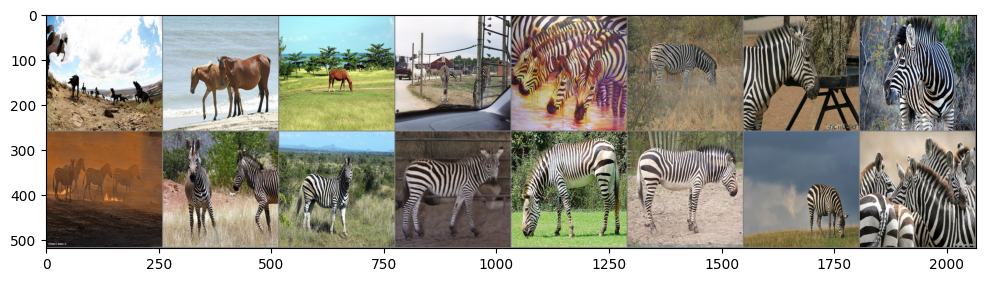

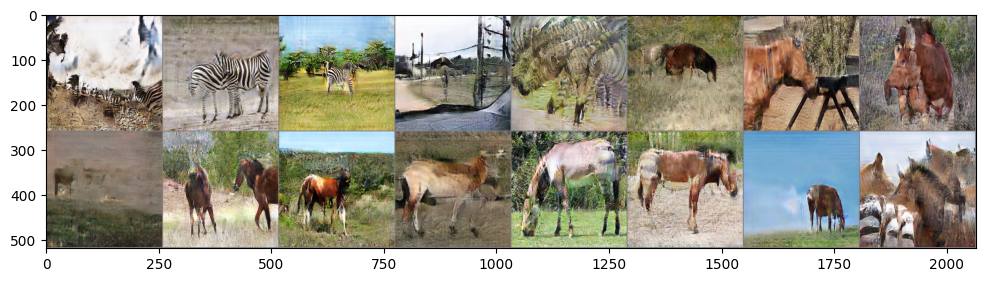

In [ ]:
visualize(netG_A2B,netG_B2A)

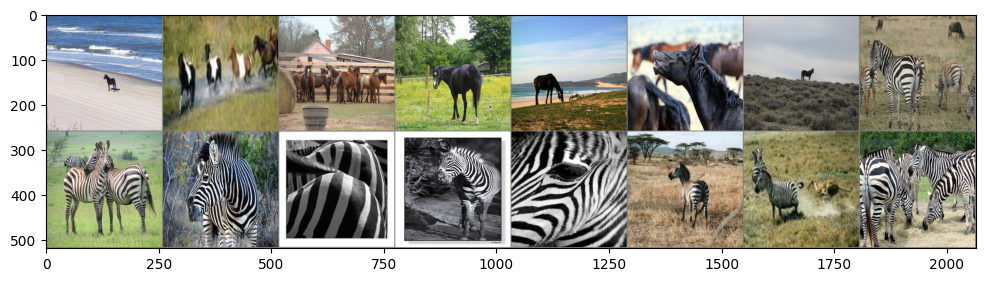

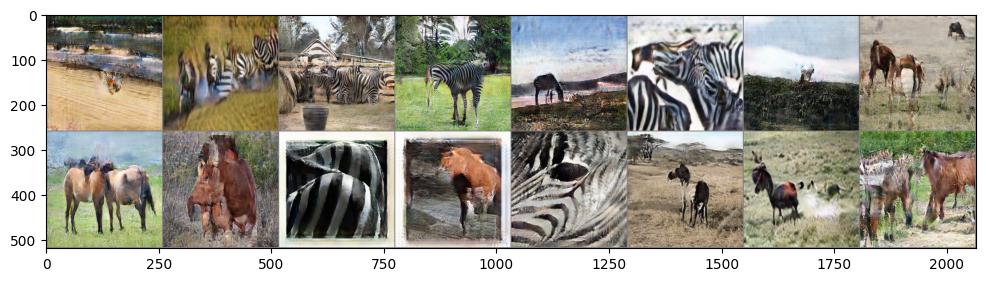

In [ ]:
visualize(netG_A2B,netG_B2A)

In [ ]:
##testing real data from internet
!wget -O horse.jpg https://pbs.twimg.com/media/GV1h6rDXUAAnwJx?format=jpg&name=large
#!wget -O horse.jpg https://encrypted-tbn2.gstatic.com/images?q=tbn:ANd9GcTUT0duIjGYNyiij5qbrkyi_Yv0tDI24VGi5W4QXsTPwCAPwPWw
#!wget -O horse.jpg https://www.theinsuranceemporium.co.uk/blog/wp-content/uploads/2023/09/image-10.png

--2024-08-27 15:35:58--  https://pbs.twimg.com/media/GV1h6rDXUAAnwJx?format=jpg
Resolving pbs.twimg.com (pbs.twimg.com)... 146.75.92.159, 2a04:4e42:87::159
Connecting to pbs.twimg.com (pbs.twimg.com)|146.75.92.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261134 (255K) [image/jpeg]
Saving to: ‘horse.jpg’

horse.jpg           100%[===================>] 255.01K  --.-KB/s    in 0.03s   

2024-08-27 15:35:58 (9.59 MB/s) - ‘horse.jpg’ saved [261134/261134]



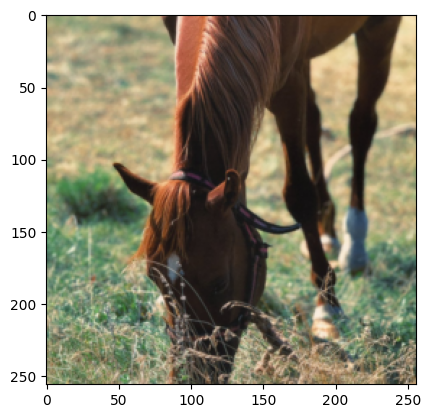

In [ ]:
img=Image.open("horse.jpg")
img=img.convert('RGB')
img=test_transform(img)
plt.imshow(np.transpose(img.numpy()*0.5+0.5, (1, 2, 0)));

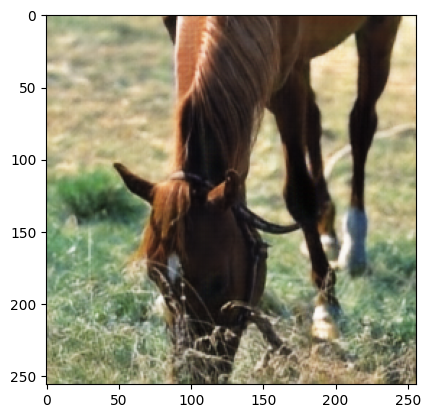

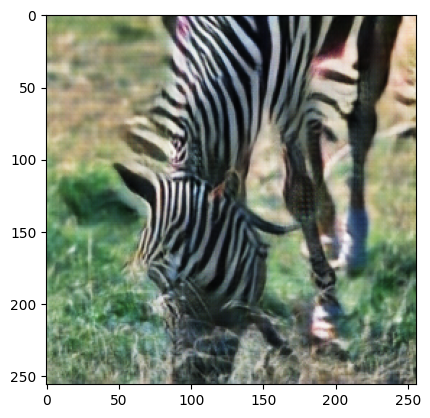

In [ ]:
with torch.no_grad():
  netG_A2B.eval()
  netG_B2A.eval()

  fake_B = netG_A2B(img.view(1,3,256,256).to(DEVICE)).cpu().view(3,256,256)
  fake_A = netG_B2A(img.view(1,3,256,256).to(DEVICE)).cpu().view(3,256,256)
  netG_A2B.train()
  netG_B2A.train()
  plt.imshow(np.transpose(fake_A.numpy()*0.5+0.5, (1, 2, 0)));
  plt.show()
  plt.imshow(np.transpose(fake_B.numpy()*0.5+0.5, (1, 2, 0)));
  plt.show()